<a href="https://colab.research.google.com/github/bintangnabiil/Deep_Learning/blob/main/Deep_Learning_Deep_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A. IMDb Dataset


##1) Load Dataset

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import tensorflow as tf

# 1. Load IMDb dataset
(imdb_train_data, imdb_test_data), _ = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

##2) Preprocessing

In [14]:
imdb_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
imdb_train_sentences, imdb_train_labels = [], []
for s, l in tfds.as_numpy(imdb_train_data):
    imdb_train_sentences.append(s.decode('utf-8'))
    imdb_train_labels.append(l)

imdb_test_sentences, imdb_test_labels = [], []
for s, l in tfds.as_numpy(imdb_test_data):
    imdb_test_sentences.append(s.decode('utf-8'))
    imdb_test_labels.append(l)

imdb_tokenizer.fit_on_texts(imdb_train_sentences)
imdb_train_seq = imdb_tokenizer.texts_to_sequences(imdb_train_sentences)
imdb_test_seq = imdb_tokenizer.texts_to_sequences(imdb_test_sentences)

imdb_maxlen = 80  # lebih pendek agar SimpleRNN tidak kolaps
imdb_train_padded = pad_sequences(imdb_train_seq, maxlen=imdb_maxlen, padding='post', truncating='post')
imdb_test_padded = pad_sequences(imdb_test_seq, maxlen=imdb_maxlen, padding='post', truncating='post')

imdb_train_labels = tf.convert_to_tensor(imdb_train_labels)
imdb_test_labels = tf.convert_to_tensor(imdb_test_labels)

##3) Build Deep RNN Model

In [15]:
imdb_model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    Bidirectional(SimpleRNN(64, return_sequences=True, activation='tanh')),
    Dropout(0.5),
    SimpleRNN(32, activation='tanh'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

imdb_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

##4) Training

In [16]:
# 4. Train model
imdb_history = imdb_model.fit(
    imdb_train_padded, imdb_train_labels,
    validation_data=(imdb_test_padded, imdb_test_labels),
    epochs=10,
    batch_size=128
)

# 5. Evaluate
imdb_loss, imdb_acc = imdb_model.evaluate(imdb_test_padded, imdb_test_labels)
print(f"\n✅ IMDb Test Accuracy (Revised Deep RNN): {imdb_acc:.4f}")

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.5586 - loss: 0.6758 - val_accuracy: 0.7702 - val_loss: 0.4931
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 178ms/step - accuracy: 0.8216 - loss: 0.4291 - val_accuracy: 0.7713 - val_loss: 0.4708
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.8721 - loss: 0.3339 - val_accuracy: 0.7865 - val_loss: 0.5236
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.9018 - loss: 0.2737 - val_accuracy: 0.7864 - val_loss: 0.5588
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.9263 - loss: 0.2131 - val_accuracy: 0.7798 - val_loss: 0.5923
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.9559 - loss: 0.1371 - val_accuracy: 0.7680 - val_loss: 0.6938
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.9686 - loss: 0.1014 - val_accuracy: 0.7720 - val_loss: 0.8770
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.9815 - loss: 0

##5) Evaluasi Matriks

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step
Classification Report (Deep RNN - IMDb):
              precision    recall  f1-score   support

           0     0.7415    0.8156    0.7768     12500
           1     0.7951    0.7156    0.7533     12500

    accuracy                         0.7656     25000
   macro avg     0.7683    0.7656    0.7650     25000
weighted avg     0.7683    0.7656    0.7650     25000



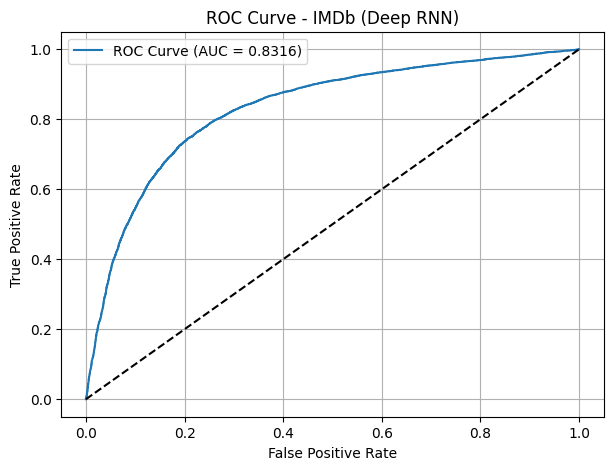

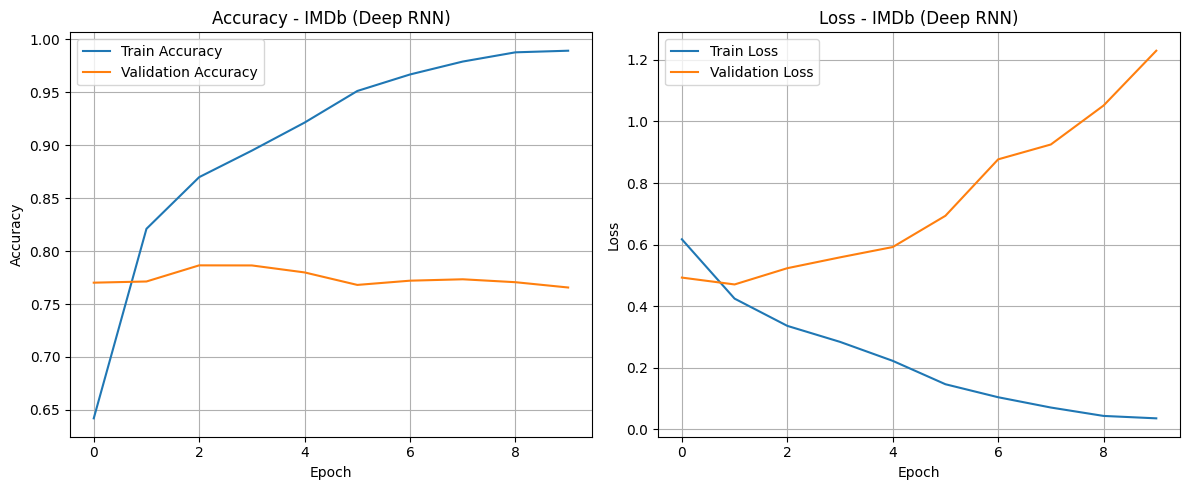

In [17]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Prediksi probabilitas dan kelas
imdb_y_pred_prob = imdb_model.predict(imdb_test_padded)
imdb_y_pred = (imdb_y_pred_prob > 0.5).astype("int32")

# Classification report
print("Classification Report (Deep RNN - IMDb):")
print(classification_report(imdb_test_labels, imdb_y_pred, digits=4))

# ROC Curve dan AUC
imdb_auc = roc_auc_score(imdb_test_labels, imdb_y_pred_prob)
imdb_fpr, imdb_tpr, _ = roc_curve(imdb_test_labels, imdb_y_pred_prob)

plt.figure(figsize=(7, 5))
plt.plot(imdb_fpr, imdb_tpr, label=f'ROC Curve (AUC = {imdb_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - IMDb (Deep RNN)')
plt.legend()
plt.grid()
plt.show()

# Plot Akurasi dan Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(imdb_history.history['accuracy'], label='Train Accuracy')
plt.plot(imdb_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy - IMDb (Deep RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(imdb_history.history['loss'], label='Train Loss')
plt.plot(imdb_history.history['val_loss'], label='Validation Loss')
plt.title('Loss - IMDb (Deep RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

##5) Hyperparameter Tuning

In [18]:
from tensorflow.keras.optimizers import Adam

# Grid Hyperparameter
imdb_embedding_dims = [32, 64]
imdb_rnn_units = [32, 64]
imdb_batch_sizes = [64, 128]
imdb_learning_rates = [1e-3, 5e-4]

# Re-pad jika belum
imdb_train_padded = pad_sequences(imdb_train_sequences, maxlen=100, padding='post', truncating='post')
imdb_test_padded = pad_sequences(imdb_test_sequences, maxlen=100, padding='post', truncating='post')

# Inisialisasi tracking terbaik
imdb_best_val_acc = 0
imdb_best_model = None
imdb_best_params = {}

for emb_dim in imdb_embedding_dims:
    for rnn_unit in imdb_rnn_units:
        for batch_size in imdb_batch_sizes:
            for lr in imdb_learning_rates:
                print(f"\n🔧 Training with emb_dim={emb_dim}, rnn_units={rnn_unit}, batch_size={batch_size}, lr={lr}")

                model = Sequential([
                    Embedding(input_dim=10000, output_dim=emb_dim, input_length=100),
                    SimpleRNN(rnn_unit, return_sequences=True, activation='tanh'),
                    SimpleRNN(rnn_unit, activation='tanh'),
                    Dense(64, activation='relu'),
                    Dense(1, activation='sigmoid')
                ])

                optimizer = Adam(learning_rate=lr)
                model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

                history = model.fit(
                    imdb_train_padded, imdb_train_labels,
                    validation_data=(imdb_test_padded, imdb_test_labels),
                    epochs=3,  # cepat untuk tuning
                    batch_size=batch_size,
                    verbose=0
                )

                val_acc = history.history['val_accuracy'][-1]
                print(f"Validation Accuracy: {val_acc:.4f}")

                if val_acc > imdb_best_val_acc:
                    imdb_best_val_acc = val_acc
                    imdb_best_model = model
                    imdb_best_params = {
                        'embedding_dim': emb_dim,
                        'rnn_units': rnn_unit,
                        'batch_size': batch_size,
                        'learning_rate': lr
                    }

print("\n✅ Best Hyperparameters Found (IMDb - Deep RNN):")
print(imdb_best_params)
print(f"Best Validation Accuracy: {imdb_best_val_acc:.4f}")


🔧 Training with emb_dim=32, rnn_units=32, batch_size=64, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation Accuracy: 0.7515

🔧 Training with emb_dim=32, rnn_units=32, batch_size=64, lr=0.0005
Validation Accuracy: 0.7812

🔧 Training with emb_dim=32, rnn_units=32, batch_size=128, lr=0.001
Validation Accuracy: 0.6272

🔧 Training with emb_dim=32, rnn_units=32, batch_size=128, lr=0.0005
Validation Accuracy: 0.7798

🔧 Training with emb_dim=32, rnn_units=64, batch_size=64, lr=0.001
Validation Accuracy: 0.5001

🔧 Training with emb_dim=32, rnn_units=64, batch_size=64, lr=0.0005
Validation Accuracy: 0.4928

🔧 Training with emb_dim=32, rnn_units=64, batch_size=128, lr=0.001
Validation Accuracy: 0.5015

🔧 Training with emb_dim=32, rnn_units=64, batch_size=128, lr=0.0005
Validation Accuracy: 0.7568

🔧 Training with emb_dim=64, rnn_units=32, batch_size=64, lr=0.001
Validation Accuracy: 0.5970

🔧 Training with emb_dim=64, rnn_units=32, batch_size=64, lr=0.0005
Validation Accuracy: 0.7722

🔧 Training with emb_dim=64, rnn_units=32, batch_size=128, lr=0.001
Validation Accuracy: 0.7941

🔧 Training 

##B. ReviewTokoBaju Dataset

##1) Load Dataset

In [19]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Load data
baju_df = pd.read_csv('/content/ReviewTokoBaju.csv')

##2) Train-test Split

In [20]:
# Ambil teks dan label
baju_texts = baju_df['Review Text'].astype(str).values
baju_labels = baju_df['Recommended IND'].values

# Train-test split
baju_X_train, baju_X_test, baju_y_train, baju_y_test = train_test_split(
    baju_texts, baju_labels, test_size=0.2, random_state=42
)

# Tokenizer & sequence
baju_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
baju_tokenizer.fit_on_texts(baju_X_train)

baju_X_train_seq = baju_tokenizer.texts_to_sequences(baju_X_train)
baju_X_test_seq = baju_tokenizer.texts_to_sequences(baju_X_test)

baju_maxlen = 100
baju_X_train_pad = pad_sequences(baju_X_train_seq, maxlen=baju_maxlen, padding='post', truncating='post')
baju_X_test_pad = pad_sequences(baju_X_test_seq, maxlen=baju_maxlen, padding='post', truncating='post')

# Convert label to numpy
baju_y_train = np.array(baju_y_train)
baju_y_test = np.array(baju_y_test)

##3) Build Deep RNN Model

In [21]:
baju_model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=baju_maxlen),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

baju_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


##4) Training

In [25]:
from sklearn.utils import class_weight

# Hitung class weight
baju_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(baju_y_train),
    y=baju_y_train
)

baju_class_weight_dict = {
    0: baju_class_weights[0],
    1: baju_class_weights[1]
}

# Latih ulang model dengan class_weight
baju_history = baju_model.fit(
    baju_X_train_pad, baju_y_train,
    validation_data=(baju_X_test_pad, baju_y_test),
    epochs=5,
    batch_size=128,
    class_weight=baju_class_weight_dict
)

# Evaluate
baju_loss, baju_acc = baju_model.evaluate(baju_X_test_pad, baju_y_test)
print(f"\nTest Accuracy (Deep RNN - Review Toko Baju): {baju_acc:.4f}")

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.5584 - loss: 0.7603 - val_accuracy: 0.1824 - val_loss: 0.7131
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.5051 - loss: 0.6971 - val_accuracy: 0.4779 - val_loss: 0.6948
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.5278 - loss: 0.6929 - val_accuracy: 0.2844 - val_loss: 0.7089
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.4699 - loss: 0.7017 - val_accuracy: 0.4117 - val_loss: 0.6975
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.4748 - loss: 0.6974 - val_accuracy: 0.4849 - val_loss: 0.6950
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4839 - loss: 0.6947

Test Accuracy (Deep RNN - Review Toko Baju): 0.4849


##5) Evaluasi Matriks dan Visualisasi

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Classification Report (Deep RNN - Review Toko Baju):
              precision    recall  f1-score   support

           0     0.2007    0.6181    0.3030       851
           1     0.8435    0.4554    0.5915      3847

    accuracy                         0.4849      4698
   macro avg     0.5221    0.5368    0.4472      4698
weighted avg     0.7271    0.4849    0.5392      4698



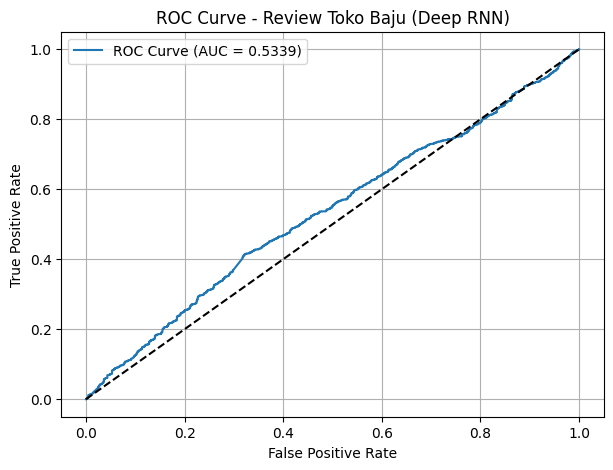

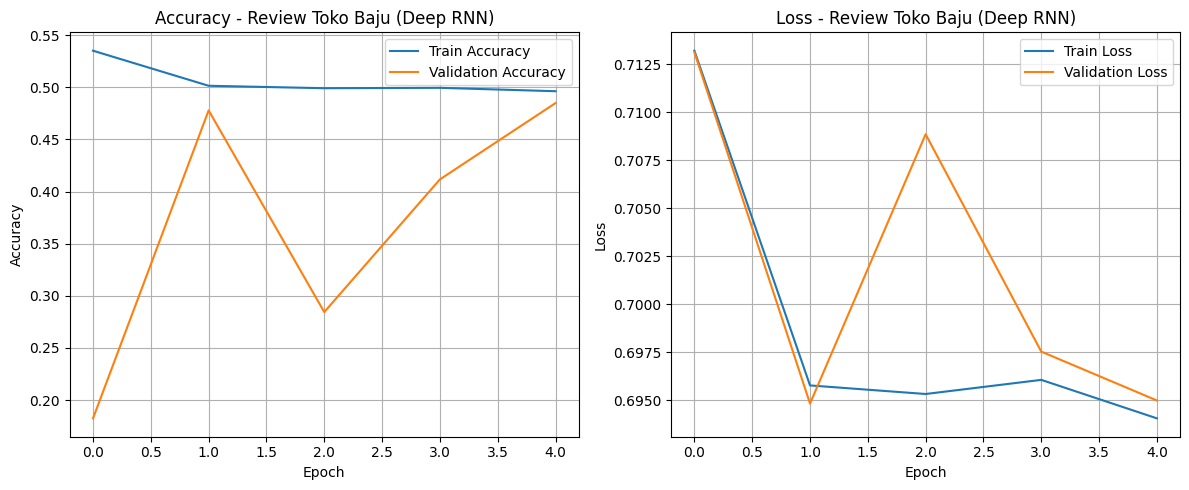

In [26]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prediksi probabilitas dan kelas
baju_y_pred_prob = baju_model.predict(baju_X_test_pad)
baju_y_pred = (baju_y_pred_prob > 0.5).astype("int32")

# Classification report
print("Classification Report (Deep RNN - Review Toko Baju):")
print(classification_report(baju_y_test, baju_y_pred, digits=4))

# ROC & AUC
baju_auc = roc_auc_score(baju_y_test, baju_y_pred_prob)
baju_fpr, baju_tpr, _ = roc_curve(baju_y_test, baju_y_pred_prob)

plt.figure(figsize=(7, 5))
plt.plot(baju_fpr, baju_tpr, label=f'ROC Curve (AUC = {baju_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Review Toko Baju (Deep RNN)')
plt.legend()
plt.grid()
plt.show()

# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(baju_history.history['accuracy'], label='Train Accuracy')
plt.plot(baju_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy - Review Toko Baju (Deep RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(baju_history.history['loss'], label='Train Loss')
plt.plot(baju_history.history['val_loss'], label='Validation Loss')
plt.title('Loss - Review Toko Baju (Deep RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Hyperparameter grids
baju_embedding_dims = [32, 64]
baju_rnn_units = [32, 64]
baju_batch_sizes = [64, 128]
baju_learning_rates = [1e-3, 5e-4]

# Tracking
baju_best_val_acc = 0
baju_best_model = None
baju_best_params = {}

for emb_dim in baju_embedding_dims:
    for rnn_unit in baju_rnn_units:
        for batch_size in baju_batch_sizes:
            for lr in baju_learning_rates:
                print(f"\n🔧 Training with emb_dim={emb_dim}, rnn_units={rnn_unit}, batch_size={batch_size}, lr={lr}")

                model = Sequential([
                    Embedding(input_dim=10000, output_dim=emb_dim, input_length=baju_maxlen),
                    SimpleRNN(rnn_unit, return_sequences=True),
                    Dropout(0.5),
                    SimpleRNN(rnn_unit),
                    Dropout(0.5),
                    Dense(64, activation='relu'),
                    Dense(1, activation='sigmoid')
                ])

                model.compile(
                    loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=lr),
                    metrics=['accuracy']
                )

                history = model.fit(
                    baju_X_train_pad, baju_y_train,
                    validation_data=(baju_X_test_pad, baju_y_test),
                    epochs=3,  # cukup untuk seleksi awal
                    batch_size=batch_size,
                    verbose=0
                )

                val_acc = history.history['val_accuracy'][-1]
                print(f"Validation Accuracy: {val_acc:.4f}")

                if val_acc > baju_best_val_acc:
                    baju_best_val_acc = val_acc
                    baju_best_model = model
                    baju_best_params = {
                        'embedding_dim': emb_dim,
                        'rnn_units': rnn_unit,
                        'batch_size': batch_size,
                        'learning_rate': lr
                    }

print("\n✅ Best Hyperparameters Found (Review Toko Baju - Deep RNN):")
print(baju_best_params)
print(f"Best Validation Accuracy: {baju_best_val_acc:.4f}")


🔧 Training with emb_dim=32, rnn_units=32, batch_size=64, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation Accuracy: 0.8189

🔧 Training with emb_dim=32, rnn_units=32, batch_size=64, lr=0.0005
Validation Accuracy: 0.8210

🔧 Training with emb_dim=32, rnn_units=32, batch_size=128, lr=0.001
Validation Accuracy: 0.8189

🔧 Training with emb_dim=32, rnn_units=32, batch_size=128, lr=0.0005
Validation Accuracy: 0.8189

🔧 Training with emb_dim=32, rnn_units=64, batch_size=64, lr=0.001
Validation Accuracy: 0.8189

🔧 Training with emb_dim=32, rnn_units=64, batch_size=64, lr=0.0005
Validation Accuracy: 0.8189

🔧 Training with emb_dim=32, rnn_units=64, batch_size=128, lr=0.001
Validation Accuracy: 0.8189

🔧 Training with emb_dim=32, rnn_units=64, batch_size=128, lr=0.0005
Validation Accuracy: 0.8189

🔧 Training with emb_dim=64, rnn_units=32, batch_size=64, lr=0.001
Validation Accuracy: 0.8189

🔧 Training with emb_dim=64, rnn_units=32, batch_size=64, lr=0.0005
Validation Accuracy: 0.8189

🔧 Training with emb_dim=64, rnn_units=32, batch_size=128, lr=0.001
Validation Accuracy: 0.8189

🔧 Training 

##C. DeteksiSarkasme Dataset

##1) Load Dataset

In [28]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Load data dari file JSON
sarkas_texts = []
sarkas_labels = []

with open('/content/DeteksiSarkasme.json', 'r') as f:
    for line in f:
        item = json.loads(line)
        sarkas_texts.append(item['headline'])
        sarkas_labels.append(item['is_sarcastic'])

##2) Split Train-Test dan Tokenisasi

In [29]:
# Split train-test
sarkas_X_train, sarkas_X_test, sarkas_y_train, sarkas_y_test = train_test_split(
    sarkas_texts, sarkas_labels, test_size=0.2, random_state=42
)

# Tokenisasi & padding
sarkas_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
sarkas_tokenizer.fit_on_texts(sarkas_X_train)

sarkas_X_train_seq = sarkas_tokenizer.texts_to_sequences(sarkas_X_train)
sarkas_X_test_seq = sarkas_tokenizer.texts_to_sequences(sarkas_X_test)

sarkas_maxlen = 40
sarkas_X_train_pad = pad_sequences(sarkas_X_train_seq, maxlen=sarkas_maxlen, padding='post', truncating='post')
sarkas_X_test_pad = pad_sequences(sarkas_X_test_seq, maxlen=sarkas_maxlen, padding='post', truncating='post')

sarkas_y_train = np.array(sarkas_y_train)
sarkas_y_test = np.array(sarkas_y_test)


##3) Build Deep RNN Model

In [30]:
sarkas_model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=sarkas_maxlen),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

sarkas_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

##4) Training

In [31]:
sarkas_history = sarkas_model.fit(
    sarkas_X_train_pad, sarkas_y_train,
    validation_data=(sarkas_X_test_pad, sarkas_y_test),
    epochs=5,
    batch_size=128
)

# Evaluasi awal
sarkas_loss, sarkas_acc = sarkas_model.evaluate(sarkas_X_test_pad, sarkas_y_test)
print(f"\nTest Accuracy (Deep RNN - Deteksi Sarkasme): {sarkas_acc:.4f}")

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.6427 - loss: 0.6106 - val_accuracy: 0.8399 - val_loss: 0.3708
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.8930 - loss: 0.2789 - val_accuracy: 0.8439 - val_loss: 0.3755
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9442 - loss: 0.1637 - val_accuracy: 0.8545 - val_loss: 0.4184
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9656 - loss: 0.1069 - val_accuracy: 0.8336 - val_loss: 0.5161
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9750 - loss: 0.0749 - val_accuracy: 0.8433 - val_loss: 0.5355
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8380 - loss: 0.5402

Test Accuracy (Deep RNN - Deteksi Sarkasme): 0.8433


##5) Evaluasi Matriks dan Visualisasi

167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Classification Report (Deep RNN - Deteksi Sarkasme):
              precision    recall  f1-score   support

           0     0.8607    0.8598    0.8602      2996
           1     0.8212    0.8223    0.8217      2346

    accuracy                         0.8433      5342
   macro avg     0.8409    0.8410    0.8410      5342
weighted avg     0.8433    0.8433    0.8433      5342



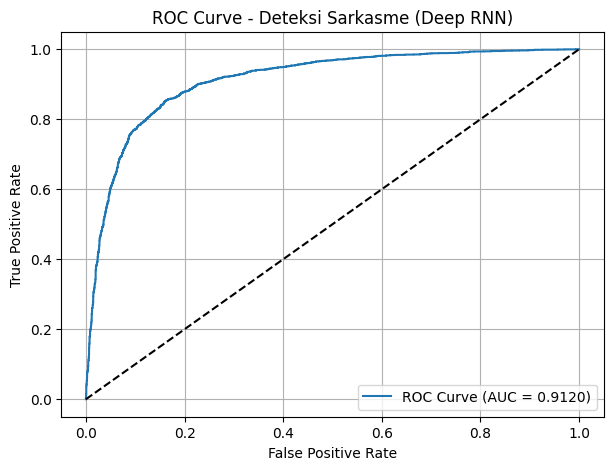

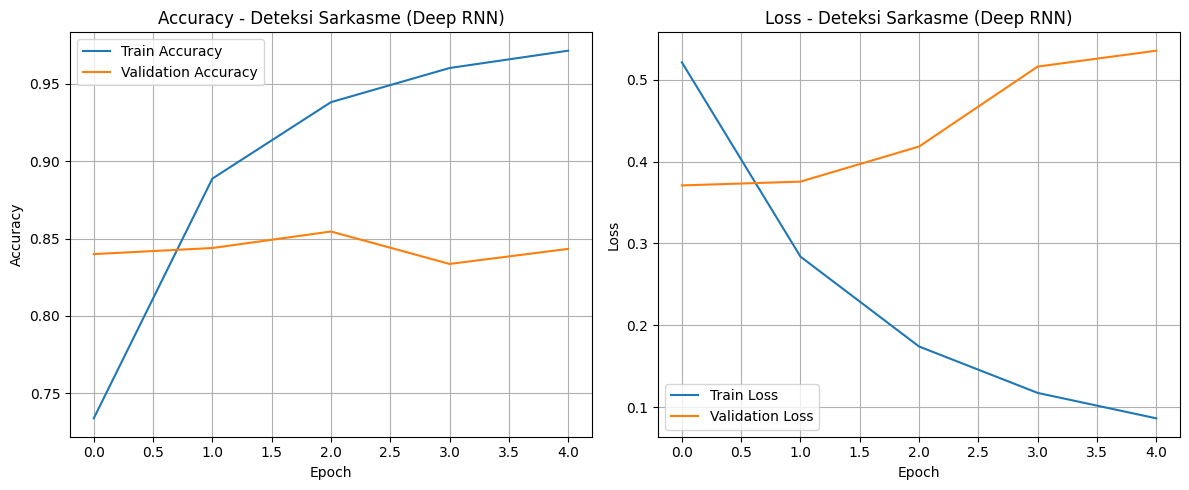

In [32]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prediksi probabilitas dan kelas
sarkas_y_pred_prob = sarkas_model.predict(sarkas_X_test_pad)
sarkas_y_pred = (sarkas_y_pred_prob > 0.5).astype("int32")

# Classification report
print("Classification Report (Deep RNN - Deteksi Sarkasme):")
print(classification_report(sarkas_y_test, sarkas_y_pred, digits=4))

# ROC & AUC
sarkas_auc = roc_auc_score(sarkas_y_test, sarkas_y_pred_prob)
sarkas_fpr, sarkas_tpr, _ = roc_curve(sarkas_y_test, sarkas_y_pred_prob)

plt.figure(figsize=(7, 5))
plt.plot(sarkas_fpr, sarkas_tpr, label=f'ROC Curve (AUC = {sarkas_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Deteksi Sarkasme (Deep RNN)')
plt.legend()
plt.grid()
plt.show()

# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sarkas_history.history['accuracy'], label='Train Accuracy')
plt.plot(sarkas_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy - Deteksi Sarkasme (Deep RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(sarkas_history.history['loss'], label='Train Loss')
plt.plot(sarkas_history.history['val_loss'], label='Validation Loss')
plt.title('Loss - Deteksi Sarkasme (Deep RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

##6) Hyperparameter Tuning

In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Grid
sarkas_embedding_dims = [32, 64]
sarkas_rnn_units = [32, 64]
sarkas_batch_sizes = [64, 128]
sarkas_learning_rates = [1e-3, 5e-4]

# Track best
sarkas_best_val_acc = 0
sarkas_best_model = None
sarkas_best_params = {}

for emb_dim in sarkas_embedding_dims:
    for rnn_unit in sarkas_rnn_units:
        for batch_size in sarkas_batch_sizes:
            for lr in sarkas_learning_rates:
                print(f"\n🔧 Training with emb_dim={emb_dim}, rnn_units={rnn_unit}, batch_size={batch_size}, lr={lr}")

                model = Sequential([
                    Embedding(input_dim=10000, output_dim=emb_dim, input_length=sarkas_maxlen),
                    SimpleRNN(rnn_unit, return_sequences=True),
                    Dropout(0.5),
                    SimpleRNN(rnn_unit),
                    Dropout(0.5),
                    Dense(64, activation='relu'),
                    Dense(1, activation='sigmoid')
                ])

                model.compile(
                    loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=lr),
                    metrics=['accuracy']
                )

                history = model.fit(
                    sarkas_X_train_pad, sarkas_y_train,
                    validation_data=(sarkas_X_test_pad, sarkas_y_test),
                    epochs=3,
                    batch_size=batch_size,
                    verbose=0
                )

                val_acc = history.history['val_accuracy'][-1]
                print(f"Validation Accuracy: {val_acc:.4f}")

                if val_acc > sarkas_best_val_acc:
                    sarkas_best_val_acc = val_acc
                    sarkas_best_model = model
                    sarkas_best_params = {
                        'embedding_dim': emb_dim,
                        'rnn_units': rnn_unit,
                        'batch_size': batch_size,
                        'learning_rate': lr
                    }

print("\n✅ Best Hyperparameters Found (Deteksi Sarkasme - Deep RNN):")
print(sarkas_best_params)
print(f"Best Validation Accuracy: {sarkas_best_val_acc:.4f}")


🔧 Training with emb_dim=32, rnn_units=32, batch_size=64, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation Accuracy: 0.8059

🔧 Training with emb_dim=32, rnn_units=32, batch_size=64, lr=0.0005
Validation Accuracy: 0.8285

🔧 Training with emb_dim=32, rnn_units=32, batch_size=128, lr=0.001
Validation Accuracy: 0.8107

🔧 Training with emb_dim=32, rnn_units=32, batch_size=128, lr=0.0005
Validation Accuracy: 0.8596

🔧 Training with emb_dim=32, rnn_units=64, batch_size=64, lr=0.001
Validation Accuracy: 0.8452

🔧 Training with emb_dim=32, rnn_units=64, batch_size=64, lr=0.0005
Validation Accuracy: 0.8487

🔧 Training with emb_dim=32, rnn_units=64, batch_size=128, lr=0.001
Validation Accuracy: 0.8555

🔧 Training with emb_dim=32, rnn_units=64, batch_size=128, lr=0.0005
Validation Accuracy: 0.8536

🔧 Training with emb_dim=64, rnn_units=32, batch_size=64, lr=0.001
Validation Accuracy: 0.8267

🔧 Training with emb_dim=64, rnn_units=32, batch_size=64, lr=0.0005
Validation Accuracy: 0.7954

🔧 Training with emb_dim=64, rnn_units=32, batch_size=128, lr=0.001
Validation Accuracy: 0.8381

🔧 Training 